In [1]:
from skimage import io
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

import joblib
import matplotlib.pyplot as plt

from napari_signal_classifier._features import get_signal_features_table, get_wavelet_coefficients_features_table, get_signal_with_wavelets_features_table
from napari_signal_classifier._utilities import plot_wavelet_coefficient_decomposition_levels


## Load Example Data

In [2]:
table = pd.read_csv('../data/signals_annotated.csv')
timelapse = io.imread('../data/synthetic_image.tif')
labels = io.imread('../data/synthetic_labels.tif')

object_id_column_name = 'label'
x_column_name = 'frame'
y_column_name = 'mean_intensity'
annotations_column_name = 'Annotations'

waveletname = 'db4'
features = ['statistics', 'crossings', 'entropy']
include_original_signal = True

In [3]:
table

,label,mean_intensity,frame,Annotations
0,1,1.918404,0,0
1,2,6.718972,0,0
2,3,0.604210,0,0
3,4,2.142554,0,0
4,5,3.419815,0,0
...,...,...,...,...
14995,26,2.949826,499,0
14996,27,4.822959,499,0
14997,28,4.575519,499,0
14998,29,3.327508,499,0


### Reshape Table

In [4]:
signals_table = table.pivot(index=object_id_column_name, columns=x_column_name, values=y_column_name)
signals_table.head(8)

frame,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
label,,,,,,,,,,,,,,,,,,,,,
1,1.918404,1.953709,1.981171,2.010182,2.063132,2.024622,2.076118,2.103976,2.069420,2.145569,...,3.765918,3.837406,3.850780,3.788736,3.806891,3.861940,3.925389,3.963102,3.899456,1.963867
2,6.718972,6.704212,6.697897,6.651067,6.631921,6.600183,6.557117,6.612905,6.579092,6.565673,...,6.560107,6.501745,6.596990,6.644004,6.590900,6.647233,6.695746,6.617459,6.689742,6.651716
3,0.604210,0.621571,0.594606,0.653429,0.671719,0.639215,0.710236,0.651085,0.727052,0.710466,...,2.328567,2.366361,2.367580,2.451611,2.496707,2.451292,2.539687,2.473051,2.580508,0.542266
4,2.142554,2.139684,2.162534,2.184816,2.254430,2.248083,2.245338,2.295281,2.325902,2.301590,...,3.966848,3.974756,3.988420,4.063709,3.995949,4.080185,4.130186,4.109903,4.167609,2.099192
5,3.419815,3.464900,3.484012,3.401669,3.427675,3.364471,3.379830,3.344644,3.366821,3.298372,...,3.330158,3.271532,3.345935,3.392070,3.416932,3.431510,3.389459,3.415822,3.427690,3.474243
6,6.743313,6.816007,6.715212,6.804241,6.758383,6.755952,6.681203,6.628126,6.671851,6.649378,...,6.639233,6.638517,6.633530,6.730117,6.701681,6.733977,6.773004,6.747572,6.725920,6.759635
7,3.860636,3.883651,3.899771,3.876482,3.918456,3.971757,3.926840,3.964528,3.984415,4.020025,...,5.654662,5.643245,5.677261,5.699159,5.743173,5.743158,5.746440,5.773131,5.791150,3.893770
8,5.786531,5.733729,5.717592,5.769584,5.722380,5.719693,5.713005,5.702723,5.715401,5.725287,...,3.719483,3.712754,3.730885,3.713808,3.756993,3.772361,3.757064,3.772190,3.729454,5.705386


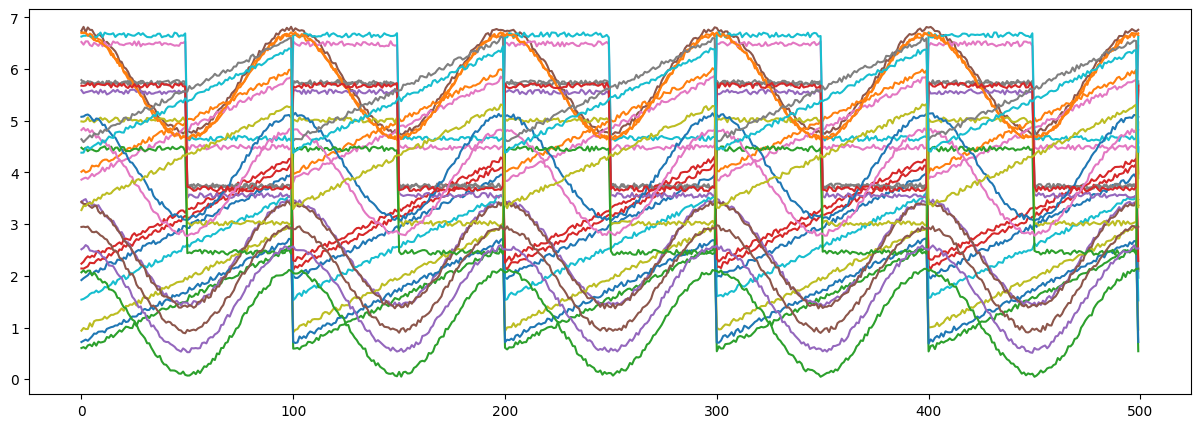

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for label, sub_df in table.groupby('label'):
    ax.plot(sub_df['frame'], sub_df['mean_intensity'])

## Get signal features table

In [6]:
signal_features_table = get_signal_features_table(signals_table, features_names=features).reset_index()
signal_features_table.head()

,label,percentile_5,percentile_25,percentile_75,percentile_95,median,mean,standard_deviation,variance,root-mean-square,n_zero_crossings,n_mean_crossings,entropy
0,1,2.062756,2.455891,3.448266,3.850862,2.938161,2.950844,0.581466,0.338103,2.950844,0,18,6.214608
1,2,4.680518,4.970950,6.375638,6.656840,5.683374,5.672132,0.710562,0.504898,5.672132,0,12,6.214608
2,3,0.657133,1.052935,2.053332,2.451308,1.564305,1.554437,0.577062,0.333000,1.554437,0,16,6.214608
3,4,2.252610,2.641103,3.627421,4.042694,3.147427,3.139515,0.577492,0.333497,3.139515,0,12,6.214608
4,5,1.468546,1.752114,3.147878,3.427747,2.436985,2.446322,0.707857,0.501062,2.446322,0,10,6.214608


## Get signal features table per wavelet decomposition level

In [7]:
wavelet_coefficients_features_table = get_wavelet_coefficients_features_table(signals_table, waveletname, features)

wavelet_coefficients_features_table.head()

,label,db4_cA_6_percentile_5,db4_cA_6_percentile_25,db4_cA_6_percentile_75,db4_cA_6_percentile_95,db4_cA_6_median,db4_cA_6_mean,db4_cA_6_standard_deviation,db4_cA_6_variance,db4_cA_6_root-mean-square,...,db4_cD_1_percentile_75,db4_cD_1_percentile_95,db4_cD_1_median,db4_cD_1_mean,db4_cD_1_standard_deviation,db4_cD_1_variance,db4_cD_1_root-mean-square,db4_cD_1_n_zero_crossings,db4_cD_1_n_mean_crossings,db4_cD_1_entropy
0,1,15.770825,15.965443,24.299981,25.207466,22.553754,20.692826,4.011347,16.090902,20.692826,...,0.022611,0.055182,-0.001612,-0.010117,0.135512,0.018364,0.047893,132,129,5.533389
1,2,42.723755,46.120344,53.392085,55.311738,47.660043,49.065909,4.576662,20.945832,49.065909,...,0.011706,0.042642,-0.004261,-0.005305,0.027946,0.000781,0.022789,127,129,5.533389
2,3,4.925397,5.091128,13.182230,13.981842,11.360223,9.634822,3.863141,14.923857,9.634822,...,0.020859,0.051671,-0.001172,-0.012538,0.139729,0.019524,0.048956,112,111,5.533389
3,4,17.316771,17.510588,25.854367,26.667491,24.038279,22.209164,3.984199,15.873839,22.209164,...,0.021134,0.050016,0.000623,-0.011496,0.138667,0.019229,0.048327,134,108,5.533389
4,5,16.952049,20.291904,27.457459,29.426354,21.887571,23.211941,4.527814,20.501102,23.211941,...,0.020295,0.047311,0.000598,0.000403,0.027943,0.000781,0.022884,118,119,5.533389


### Plot wavelet coefficients

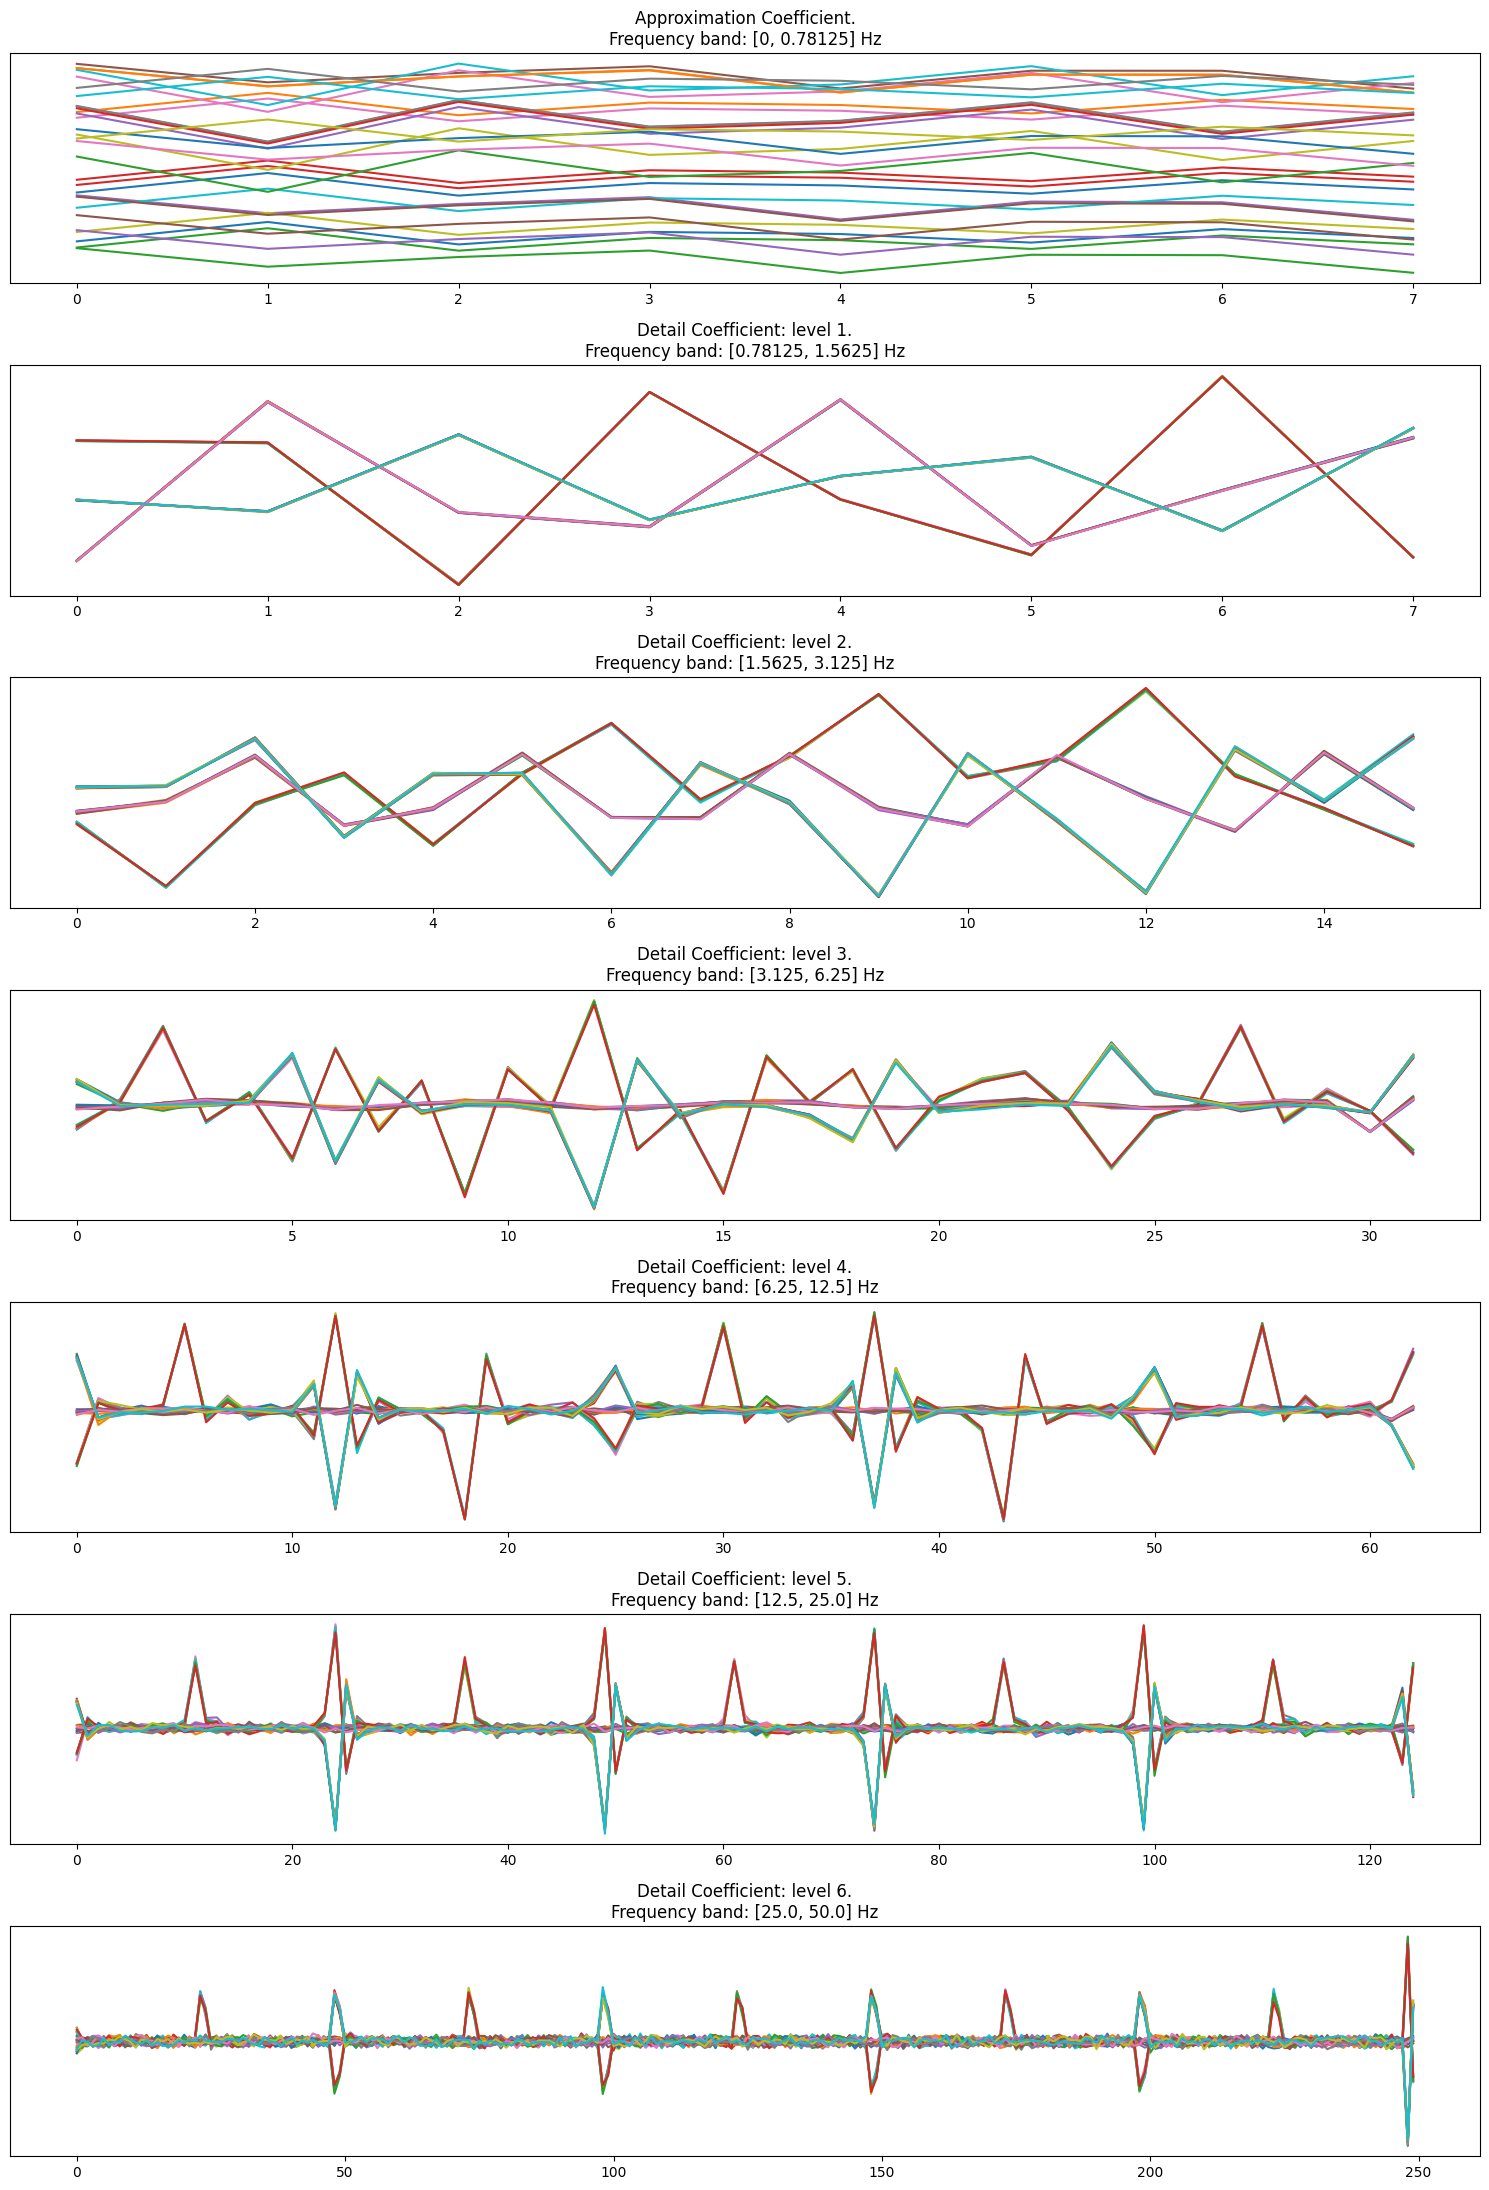

In [8]:
fig, ax = plot_wavelet_coefficient_decomposition_levels(signals_table, waveletname='db4', sampling_frequency=100)

In [9]:
signal_features_table = get_signal_with_wavelets_features_table(signals_table, waveletname, features, include_original_signal)
signal_features_table.head()


,label,db4_cA_6_percentile_5,db4_cA_6_percentile_25,db4_cA_6_percentile_75,db4_cA_6_percentile_95,db4_cA_6_median,db4_cA_6_mean,db4_cA_6_standard_deviation,db4_cA_6_variance,db4_cA_6_root-mean-square,...,percentile_75,percentile_95,median,mean,standard_deviation,variance,root-mean-square,n_zero_crossings,n_mean_crossings,entropy
0,1,15.770825,15.965443,24.299981,25.207466,22.553754,20.692826,4.011347,16.090902,20.692826,...,3.448266,3.850862,2.938161,2.950844,0.581466,0.338103,2.950844,0,18,6.214608
1,2,42.723755,46.120344,53.392085,55.311738,47.660043,49.065909,4.576662,20.945832,49.065909,...,6.375638,6.656840,5.683374,5.672132,0.710562,0.504898,5.672132,0,12,6.214608
2,3,4.925397,5.091128,13.182230,13.981842,11.360223,9.634822,3.863141,14.923857,9.634822,...,2.053332,2.451308,1.564305,1.554437,0.577062,0.333000,1.554437,0,16,6.214608
3,4,17.316771,17.510588,25.854367,26.667491,24.038279,22.209164,3.984199,15.873839,22.209164,...,3.627421,4.042694,3.147427,3.139515,0.577492,0.333497,3.139515,0,12,6.214608
4,5,16.952049,20.291904,27.457459,29.426354,21.887571,23.211941,4.527814,20.501102,23.211941,...,3.147878,3.427747,2.436985,2.446322,0.707857,0.501062,2.446322,0,10,6.214608


## Train Classifier

### Load Annotations

In [10]:
table_training = table[table[annotations_column_name] > 0]

signals_table_training = table_training.pivot(index=object_id_column_name, columns=x_column_name, values=y_column_name)

signals_table_training

frame,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
label,,,,,,,,,,,,,,,,,,,,,
7,3.860636,3.883651,3.899771,3.876482,3.918456,3.971757,3.926840,3.964528,3.984415,4.020025,...,5.654662,5.643245,5.677261,5.699159,5.743173,5.743158,5.746440,5.773131,5.791150,3.893770
12,4.013734,4.044111,4.000985,4.015121,4.039282,4.132483,4.117629,4.131576,4.115562,4.189886,...,5.849824,5.794173,5.813361,5.850599,5.931846,5.877300,5.956449,5.914606,5.986844,3.980177
13,2.068860,2.107430,2.061142,2.099073,2.101316,2.009033,2.061649,2.009300,1.934023,1.931965,...,1.907902,1.927978,2.049798,1.977471,2.079877,2.050485,2.111869,2.093036,2.133673,2.138110
17,6.523326,6.472462,6.535120,6.535789,6.464643,6.441913,6.508322,6.482914,6.447891,6.508568,...,4.515951,4.505820,4.501331,4.528771,4.439619,4.493520,4.516550,4.491949,4.470205,6.451440
20,6.628451,6.644373,6.644575,6.656684,6.643192,6.620514,6.624341,6.613122,6.656803,6.705223,...,4.610312,4.708265,4.697561,4.699289,4.675703,4.644257,4.699143,4.638930,4.666049,6.619751
25,2.513998,2.542065,2.594851,2.567506,2.488896,2.483082,2.466924,2.473932,2.455964,2.423117,...,2.406182,2.446441,2.481009,2.459465,2.464231,2.480770,2.529276,2.591112,2.524236,2.530118


In [11]:
signal_features_table_training = get_signal_with_wavelets_features_table(signals_table_training, waveletname, features, include_original_signal)
signal_features_table_training.head()

,label,db4_cA_6_percentile_5,db4_cA_6_percentile_25,db4_cA_6_percentile_75,db4_cA_6_percentile_95,db4_cA_6_median,db4_cA_6_mean,db4_cA_6_standard_deviation,db4_cA_6_variance,db4_cA_6_root-mean-square,...,percentile_75,percentile_95,median,mean,standard_deviation,variance,root-mean-square,n_zero_crossings,n_mean_crossings,entropy
0,7,31.022987,31.205995,39.459480,40.333896,37.660676,35.866465,3.959503,15.677665,35.866465,...,5.342474,5.725486,4.851778,4.842273,0.577228,0.333192,4.842273,0,14,6.214608
1,12,32.120860,32.315479,40.629459,41.494277,38.867423,37.017443,3.985999,15.888191,37.017443,...,5.496975,5.882942,4.986208,4.990919,0.578909,0.335136,4.990919,0,14,6.214608
2,13,6.151132,9.499187,16.640205,18.682635,11.098821,12.423915,4.544747,20.654722,12.423915,...,1.794021,2.084439,1.104272,1.097148,0.708916,0.502562,1.097148,0,10,6.214608
3,17,41.291683,42.477929,51.992196,52.106435,46.373077,47.024986,4.567584,20.862828,47.024986,...,6.484594,6.529175,6.438306,5.490301,1.000664,1.001329,5.490301,0,10,6.214608
4,20,42.682020,43.812494,53.138800,53.226153,47.752689,48.297611,4.452942,19.828688,48.297611,...,6.657081,6.698267,6.610497,5.662339,0.999318,0.998637,5.662339,0,10,6.214608


In [12]:
annotations = table_training.groupby(object_id_column_name).mean()['Annotations'].values
annotations

array([2., 2., 1., 3., 3., 1.])

### Train Classifier

In [13]:
random_state = 42
classifier = RandomForestClassifier(random_state=random_state)
classifier_path = 'signal_classifier.pkl'

X_train = signal_features_table_training.iloc[:, 1:] # remove the first column (the object_id)

classifier.fit(X_train, annotations)

train_score = classifier.score(X_train, annotations)
print(train_score)
# Save classifier to disk
# joblib.dump(classifier, classifier_path)

1.0


## Run Predictions

### Load all signals

In [14]:
signals_table = table.pivot(index=object_id_column_name, columns=x_column_name, values=y_column_name)


### Calculate features for all signals

In [15]:

signal_features_table = get_signal_with_wavelets_features_table(signals_table, waveletname, features, include_original_signal)

X_pred = signal_features_table.iloc[:, 1:] # remove the first column (the object_id)



### Run predictions

In [16]:
# Run predictions on all signals
Y_pred = classifier.predict(X_pred)
Y_pred

array([2., 1., 2., 2., 1., 1., 2., 3., 2., 2., 2., 2., 1., 2., 3., 1., 3.,
       3., 3., 3., 1., 1., 3., 3., 1., 1., 1., 2., 2., 2.])

### Add predictions to table

In [17]:
# Expand labels to match the number of frames
number_of_frames = table[x_column_name].max() + 1
Y_pred = np.repeat(Y_pred.tolist(), number_of_frames)

# Add predictions to table
table = table.sort_values([object_id_column_name, x_column_name])
table['Predictions'] = Y_pred.astype(int)

table

,label,mean_intensity,frame,Annotations,Predictions
0,1,1.918404,0,0,2
30,1,1.953709,1,0,2
60,1,1.981171,2,0,2
90,1,2.010182,3,0,2
120,1,2.063132,4,0,2
...,...,...,...,...,...
14879,30,6.329745,495,0,2
14909,30,6.305856,496,0,2
14939,30,6.356106,497,0,2
14969,30,6.367115,498,0,2


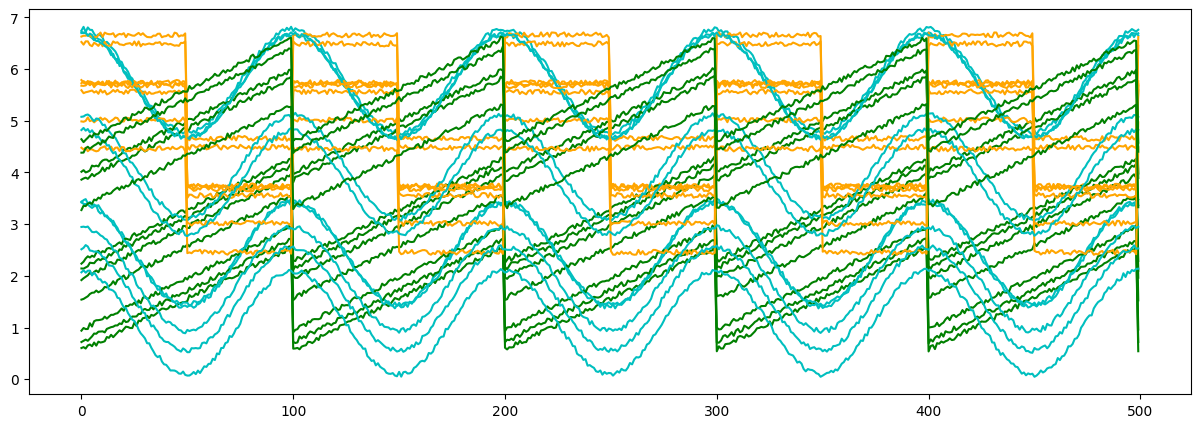

In [18]:
color_dict = {1: 'c', 2: 'g', 3: 'orange'}

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for label, sub_df in table.groupby('label'):
    ax.plot(sub_df['frame'], sub_df['mean_intensity'], color=color_dict[sub_df['Predictions'].iloc[0]])